In [1]:
# Step 1: run this cell in Colab

# 1) show GPU status (if available)
!nvidia-smi || true

# 2) list files in /content to confirm your uploaded zips (dataset1.zip, dataset2.zip)
!ls -la /content

# 3) install essential packages (pyarrow to read parquet; pandas + sklearn for baseline)
!pip install -q pyarrow pandas scikit-learn imbalanced-learn joblib

# 4) quick python check (prints versions and lists files)
import os
import pandas as pd
try:
    import pyarrow as pa
    pa_ok = True
except Exception as e:
    pa_ok = False
print("pandas:", pd.__version__)
print("pyarrow installed:", pa_ok)
print("Files in /content:", os.listdir("/content"))

Fri Oct  3 21:54:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Step 2: Unzip both datasets into their own folders
!mkdir -p /content/dataset1 /content/dataset2

!unzip -q /content/dataset1.zip -d /content/dataset1
!unzip -q /content/dataset2.zip -d /content/dataset2

# Show the folder structure to see what files are inside
!ls -R /content/dataset1 | head -n 20
print("\n--- Dataset2 ---\n")
!ls -R /content/dataset2 | head -n 20


/content/dataset1:
test-00000-of-00001-92a580ceaea25bf5.parquet
train-00000-of-00001-4ecde15228eb0f64.parquet
validation-00000-of-00001-ffb59746b9938005.parquet

--- Dataset2 ---

/content/dataset2:
test.parquet
train.csv
train.parquet
validation.parquet


In [3]:
import pandas as pd

# Step 3a: Load Dataset1 (all parquet)
train1 = pd.read_parquet("/content/dataset1/train-00000-of-00001-4ecde15228eb0f64.parquet")
val1   = pd.read_parquet("/content/dataset1/validation-00000-of-00001-ffb59746b9938005.parquet")
test1  = pd.read_parquet("/content/dataset1/test-00000-of-00001-92a580ceaea25bf5.parquet")

print("Dataset1 Shapes:")
print("Train1:", train1.shape, "Validation1:", val1.shape, "Test1:", test1.shape)


# Step 3b: Load Dataset2
# train is available both as CSV and Parquet — we'll load CSV for clarity
train2 = pd.read_csv("/content/dataset2/train.csv")
val2   = pd.read_parquet("/content/dataset2/validation.parquet")
test2  = pd.read_parquet("/content/dataset2/test.parquet")

print("\nDataset2 Shapes:")
print("Train2:", train2.shape, "Validation2:", val2.shape, "Test2:", test2.shape)


# Step 3c: Peek at first rows to see structure
print("\nDataset1 sample:")
print(train1.head())

print("\nDataset2 sample:")
print(train2.head())


Dataset1 Shapes:
Train1: (1584, 3) Validation1: (212, 3) Test1: (318, 3)

Dataset2 Shapes:
Train2: (5550, 3) Validation2: (212, 3) Test2: (318, 3)

Dataset1 sample:
     id  label                                          texts
0  3144      1                     Ah, so I have been told ;)
1  2086      0                                    just honest
2  2826      0              i'm trying to get into med school
3  2993      1  The rhythm of your heart is music to my ears.
4  2016      0                  hi, not bad, how about yours?

Dataset2 sample:
     id  label                                          texts
0  3144      1                     Ah, so I have been told ;)
1  2086      0                                    just honest
2  2826      0              i'm trying to get into med school
3  2993      1  The rhythm of your heart is music to my ears.
4  2016      0                  hi, not bad, how about yours?


In [4]:
import re

# Step 4a: Keep only "text" and "label"
def prepare(df):
    df = df[['texts', 'label']].copy()
    df = df.rename(columns={'texts': 'text'})
    return df

train1 = prepare(train1)
val1   = prepare(val1)
test1  = prepare(test1)

train2 = prepare(train2)
val2   = prepare(val2)
test2  = prepare(test2)


# Step 4b: Clean text
def clean_text(s):
    s = str(s)
    s = re.sub(r"http\S+", " ", s)        # remove URLs
    s = re.sub(r"@\w+", " ", s)           # remove @mentions
    s = re.sub(r"<.*?>", " ", s)          # remove HTML tags
    s = re.sub(r"\s+", " ", s).strip()    # remove extra spaces
    return s

for df in [train1, val1, test1, train2, val2, test2]:
    df['text'] = df['text'].apply(clean_text)


# Step 4c: Combine datasets
train = pd.concat([train1, train2], ignore_index=True)
val   = pd.concat([val1, val2], ignore_index=True)
test  = pd.concat([test1, test2], ignore_index=True)

print("Unified Dataset Shapes:")
print("Train:", train.shape, "Validation:", val.shape, "Test:", test.shape)

print("\nSample from combined train:")
print(train.sample(5))


Unified Dataset Shapes:
Train: (7134, 2) Validation: (424, 2) Test: (636, 2)

Sample from combined train:
                                                   text  label
252   apparently everyone in the tinderverse likes s...      1
2001  That's how your going to feel when I spread yo...      1
6176  and i eat all other dairy products, it's just ...      0
3542  Miss seeing you look back while pounding you b...      1
3529  I’m glad you wanna eat my ass too, it’s been a...      1


In [5]:
# Save the combined datasets
train.to_csv("/content/train_combined.csv", index=False)
val.to_csv("/content/val_combined.csv", index=False)
test.to_csv("/content/test_combined.csv", index=False)

print("Files saved!")
!ls -lh /content | grep combined


Files saved!
-rw-r--r-- 1 root root  30K Oct  3 21:54 test_combined.csv
-rw-r--r-- 1 root root 408K Oct  3 21:54 train_combined.csv
-rw-r--r-- 1 root root  21K Oct  3 21:54 val_combined.csv


Train label distribution:
 label
0    3955
1    3179
Name: count, dtype: int64

Validation label distribution:
 label
0    212
1    212
Name: count, dtype: int64

Test label distribution:
 label
1    318
0    318
Name: count, dtype: int64


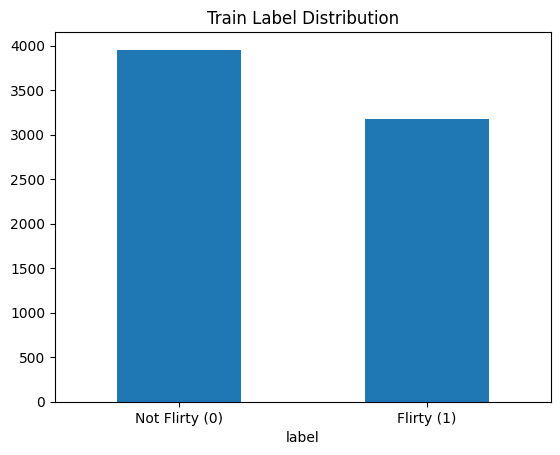

In [6]:
import matplotlib.pyplot as plt

# Count labels in each split
print("Train label distribution:\n", train['label'].value_counts())
print("\nValidation label distribution:\n", val['label'].value_counts())
print("\nTest label distribution:\n", test['label'].value_counts())

# Quick visualization for train
train['label'].value_counts().plot(kind='bar', title="Train Label Distribution")
plt.xticks([0,1], ['Not Flirty (0)', 'Flirty (1)'], rotation=0)
plt.show()


In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [8]:
train = pd.read_csv("/content/train_combined.csv")
val   = pd.read_csv("/content/val_combined.csv")
test  = pd.read_csv("/content/test_combined.csv")

print(train.shape, val.shape, test.shape)


(7134, 2) (424, 2) (636, 2)


In [9]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
# max_features=10000 keeps vocab manageable
# ngram_range=(1,2) uses unigrams + bigrams for context

# Drop rows with NaN values in the 'text' column
train.dropna(subset=['text'], inplace=True)
val.dropna(subset=['text'], inplace=True)
test.dropna(subset=['text'], inplace=True)

X_train = vectorizer.fit_transform(train['text'])
X_val   = vectorizer.transform(val['text'])
X_test  = vectorizer.transform(test['text'])

y_train = train['label']
y_val   = val['label']
y_test  = test['label']

In [10]:
model = LogisticRegression(max_iter=200, class_weight='balanced')
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=200)

In [11]:
y_val_pred = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


Validation Accuracy: 0.7169811320754716
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       212
           1       0.69      0.80      0.74       212

    accuracy                           0.72       424
   macro avg       0.72      0.72      0.71       424
weighted avg       0.72      0.72      0.71       424



In [12]:
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.7310126582278481
              precision    recall  f1-score   support

           0       0.77      0.66      0.71       318
           1       0.70      0.80      0.75       314

    accuracy                           0.73       632
   macro avg       0.74      0.73      0.73       632
weighted avg       0.74      0.73      0.73       632



In [13]:
!pip install transformers datasets evaluate accelerate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.1 MB/s eta 0:00:00


In [14]:
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, EarlyStoppingCallback
from transformers import TrainingArguments, Trainer
import evaluate
import torch


In [15]:
train = pd.read_csv("/content/train_combined.csv")
val   = pd.read_csv("/content/val_combined.csv")
test  = pd.read_csv("/content/test_combined.csv")

print(train.shape, val.shape, test.shape)


(7134, 2) (424, 2) (636, 2)


In [16]:
train_ds = Dataset.from_pandas(train[['text','label']])
val_ds   = Dataset.from_pandas(val[['text','label']])
test_ds  = Dataset.from_pandas(test[['text','label']])


In [17]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize(batch):
    # Tokenize each text in the batch
    texts = [str(t) for t in batch["text"]]
    return tokenizer(texts,
                     padding=True,
                     truncation=True,
                    #  max_length=150
                     )

train_ds = train_ds.map(tokenize, batched=True)
val_ds   = val_ds.map(tokenize, batched=True)
test_ds  = test_ds.map(tokenize, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/7134 [00:00<?, ? examples/s]

Map:   0%|          | 0/424 [00:00<?, ? examples/s]

Map:   0%|          | 0/636 [00:00<?, ? examples/s]

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Corrected parameter name
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.001,
    lr_scheduler_type="linear",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    logging_dir='./logs',
    logging_steps=50,
    push_to_hub=False
)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import evaluate

accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)

    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


/tmp/ipython-input-3413024494.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muhammad-asad-2972 (muhammad-asad-2972-iqra-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.187900,0.649713,0.801887,0.753968,0.896226,0.818966
2,0.069800,0.566714,0.839623,0.833333,0.849057,0.841121
3,0.013100,0.912279,0.849057,0.842593,0.858491,0.850467
4,0.010000,0.942993,0.844340,0.834862,0.858491,0.846512


TrainOutput(global_step=892, training_loss=0.10307779600802024, metrics={'train_runtime': 724.0151, 'train_samples_per_second': 39.414, 'train_steps_per_second': 1.232, 'total_flos': 2052743120595840.0, 'train_loss': 0.10307779600802024, 'epoch': 4.0})

In [23]:
trainer.evaluate(test_ds)


{'eval_loss': 0.6919524073600769,
 'eval_accuracy': 0.7987421383647799,
 'eval_precision': 0.8145695364238411,
 'eval_recall': 0.7735849056603774,
 'eval_f1': 0.7935483870967742,
 'eval_runtime': 2.0963,
 'eval_samples_per_second': 303.397,
 'eval_steps_per_second': 9.541,
 'epoch': 4.0}

In [24]:
# Create folder and save model + tokenizer
save_path = "/content/flirty_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved at:", save_path)


Model saved at: /content/flirty_model


In [25]:
!ls -lh /content/flirty_model


total 419M
-rw-r--r-- 1 root root  681 Oct  3 22:08 config.json
-rw-r--r-- 1 root root 418M Oct  3 22:08 model.safetensors
-rw-r--r-- 1 root root  125 Oct  3 22:08 special_tokens_map.json
-rw-r--r-- 1 root root 1.2K Oct  3 22:08 tokenizer_config.json
-rw-r--r-- 1 root root 695K Oct  3 22:08 tokenizer.json
-rw-r--r-- 1 root root 5.7K Oct  3 22:08 training_args.bin
-rw-r--r-- 1 root root 227K Oct  3 22:08 vocab.txt


In [26]:
!zip -r flirty_model.zip /content/flirty_model
from google.colab import files
files.download("flirty_model.zip")


  adding: content/flirty_model/ (stored 0%)
  adding: content/flirty_model/tokenizer.json (deflated 71%)
  adding: content/flirty_model/model.safetensors (deflated 7%)
  adding: content/flirty_model/config.json (deflated 49%)
  adding: content/flirty_model/tokenizer_config.json (deflated 75%)
  adding: content/flirty_model/special_tokens_map.json (deflated 42%)
  adding: content/flirty_model/training_args.bin (deflated 54%)
  adding: content/flirty_model/vocab.txt (deflated 53%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from transformers import pipeline

clf = pipeline("text-classification", model="/content/flirty_model", tokenizer="/content/flirty_model")

print(clf("There's something wrong with my phone, it doesn't have your number in it."))
print(clf("Did you just come out of an oven? Because you're too hot to handle."))


HFValidationError: Repo id must be in the form 'repo_name' or 'namespace/repo_name': '/content/flirty_model'. Use `repo_type` argument if needed.